# Cyber Use Case Tutorial: Multiclass Classification on IoT Flow Data with XGBoost

### Goals:
- Learn the basics of cyber network data with respect to consumer IoT devices
- Load network data into a cuDF
- Explore network data and features
- Use XGBoost to build a classification model
- Evaluate the model

In [6]:
%%sh 
pwd

/rapids/notebooks/host_folder/todrabas/MLADS_RAPIDS/notebook


To get started, we'll make sure the data is available and in the expected location. If you already have the data on your machine, change the `DATA_PATH` location to point to the appropriate location.

In [9]:
%%script sh --out /dev/null --err /dev/null
mkdir -p ../data/unswiot && \
cd ../data/unswiot && \
wget -O unswiotflow.tar.gz https://github.com/rapidsai/notebooks-extended/blob/master/data/unswiot/unswiotflow.tar.gz?raw=true

In [10]:
!mkdir -p ../data/input/unswiot
!if [ ! -f ../data/input/unswiot/conn.log ]; then tar -xzvf ../data/unswiot/unswiotflow.tar.gz -C ../data/input/unswiot/; fi

conn.log
lab_mac_labels_cats.csv
small_sample.pcap


In [11]:
# specify the location of the data files
DATA_PATH = "../data/input/unswiot/"

# the sample PCAP file used for explanation 
DATA_PCAP = DATA_PATH + "small_sample.pcap"

# the flow connection log (conn.log) file
DATA_SOURCE = DATA_PATH + "conn.log"

# the data label file (matches IP addresses with MAC addresses)
DATA_LABELS = DATA_PATH + "lab_mac_labels_cats.csv"

### Background

#### Types of Network Data
The most detailed type of data that is typically collected on a network is full Packet CAPture (PCAP) data. This information is detailed and contains everything about the communication, including: source address, destination address, protocols used, bytes transferred, and even the raw data (e.g., image, audio file, executable). PCAP data is fine-grained, meaning that there is a record for each frame being transmitted. A typical communication is composed of many individual packets/frames.

If we aggregate PCAP data so that there is one row of data per communication session, we call that flow level data. A simplified example of this relationship is shown in the figure below.

![PCAP_flow_relationship](images/pcap_vs_flow.png "PCAP vs FLOW")

For this tutorial, we use data from the University of New South Wales. In a lab environment, they [collected nearly three weeks of IoT data from 21 IoT devices](http://149.171.189.1). They also kept a detailed [list of devices by MAC address](http://149.171.189.1/resources/List_Of_Devices.txt), so we have ground-truth with respect to each IoT device's behavior on the network.

**Our goal is to utilize the behavior exhibited in the network data to classify IoT devices.**

#### The Internet of Things and Data at a Massive Scale
Gartner estimates there are currently over 8.4 billion Internet of Things (IoT) devices. By 2020, that number is [estimated to surpass 20 billion](https://www.zdnet.com/article/iot-devices-will-outnumber-the-worlds-population-this-year-for-the-first-time/). These types of devices range from consumer devices (e.g., Amazon Echo, smart TVs, smart cameras, door bells) to commercial devices (e.g., building automation systems, keycard entry). All of these devices exhibit behavior on the Internet as they communicate back with their own clouds and user-specified integrations.

## Data Investigation

Let's first see some of the data. We'll load a PCAP file in using Scapy. If you don't want to or can't install Scapy, feel free to skip this section.

In [13]:
!pip install scapy

In [14]:
from scapy.all import *
cap = rdpcap(DATA_PCAP)

In [15]:
eth_frame = cap[3]
ip_pkt = eth_frame.payload
segment = ip_pkt.payload
data = segment.payload

In [16]:
eth_frame.show()

###[ Ethernet ]### 
  dst       = 14:cc:20:51:33:ea
  src       = 30:8c:fb:2f:e4:b2
  type      = 0x800
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 142
     id        = 55213
     flags     = DF
     frag      = 0
     ttl       = 64
     proto     = 6
     chksum    = 0x7ab3
     src       = 192.168.1.106
     dst       = 52.87.241.159
     \options   \
###[ TCP ]### 
        sport     = 40767
        dport     = 443
        seq       = 91355963
        ack       = 679917399
        dataofs   = 8
        reserved  = 0
        flags     = PA
        window    = 2549
        chksum    = 0xd703
        urgptr    = 0
        options   = [('NOP', None), ('NOP', None), ('Timestamp', (23325908, 4049739322))]
###[ Raw ]### 
           load      = '\x17\x03\x01\x00 |\xa0\xa9"[\xe1\x7f>\x88\xccP=\xb6\x1c\xdf\xa9u\x82z\xf2G\xaaH\x82/mV\xac\x97\xe7l\x19\x17\x03\x01\x000\x95\xd9\x85wV\xb9u\xf7N\xb6>\x14\xae\xcf\x9f\xbbD\xae\x11"\xc0\xedw\x1c\xfa0\xa1:\

There's really a lot of features there. In addition to having multiple layers (which may differ between packets), there are a number of other issues with working directly with PCAP. Often the payload (the `Raw` section above) is encrypted, rendering it useless. The lack of aggregation also makes it difficult to differentiate between packets. What we really care about for this application is what a *session* looks like. In other words, how a Roku interacts with the network is likely quite different than how a Google Home interacts. 

To save time for the tutorial, all three weeks of PCAP data have already been transformed to flow data, and we can load that in to a typical Pandas dataframe. Due to how the data was created, we have a header row (with column names) as well as a footer row. We've already removed those rows, so nothing to do here.

For this application, we used [Zeek](https://www.zeek.org) (formerly known as Bro) to construct the flow data. To include MAC addresses in the conn log, we used the [mac-logging.zeek script](https://github.com/bro/bro/blob/master/scripts/policy/protocols/conn/mac-logging.zeek).

If you've skipped installing Scapy, you can pick up here.

In [17]:
import cudf as cd
import pandas as pd
import nvstrings
from collections import OrderedDict

In [18]:
%%time
pdf = pd.read_csv(DATA_SOURCE, sep='\t')
print("==> pdf shape: ",pdf.shape)

==> pdf shape:  (950384, 23)
CPU times: user 1.98 s, sys: 143 ms, total: 2.12 s
Wall time: 2.12 s


We can look at what this new aggregated data looks like, and get a better sense of the columns and their data types. Let's do this the way we're familiar with, using Pandas.

In [19]:
pdf.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,orig_l2_addr,resp_l2_addr
0,1.474553e+09,CIlOTU4kRBDOEJ2zf,192.168.1.241,61725,192.168.1.1,53,udp,dns,-,-,...,-,0,Dc,1,74,0,0,-,70:ee:50:18:34:43,14:cc:20:51:33:ea
1,1.474553e+09,CmV0US1aCCPzrVRz36,192.168.1.193,4425,192.168.1.223,49153,tcp,http,0.008820,196,...,-,0,ShADadfF,5,464,5,461,-,ec:1a:59:83:28:11,ec:1a:59:79:f4:89
2,1.474553e+09,CEXvDL2UPDYnBDtd6h,192.168.1.193,4426,192.168.1.223,49153,tcp,http,0.008664,198,...,-,0,ShADadfF,5,466,5,461,-,ec:1a:59:83:28:11,ec:1a:59:79:f4:89
3,1.474553e+09,CEXDAD42Irgl4M5go8,192.168.1.193,4977,192.168.1.249,49152,tcp,http,0.020995,186,...,-,0,ShADadfF,5,454,5,1438,-,ec:1a:59:83:28:11,00:16:6c:ab:6b:88
4,1.474553e+09,CW1YbA2fZzHrztJ0rl,192.168.1.193,4978,192.168.1.249,49152,tcp,http,0.018730,186,...,-,0,ShADadfF,5,454,5,1438,-,ec:1a:59:83:28:11,00:16:6c:ab:6b:88


In [20]:
pdf.dtypes

ts                float64
uid                object
id.orig_h          object
id.orig_p           int64
id.resp_h          object
id.resp_p           int64
proto              object
service            object
duration           object
orig_bytes         object
resp_bytes         object
conn_state         object
local_orig         object
local_resp         object
missed_bytes        int64
history            object
orig_pkts           int64
orig_ip_bytes       int64
resp_pkts           int64
resp_ip_bytes       int64
tunnel_parents     object
orig_l2_addr       object
resp_l2_addr       object
dtype: object

That's Pandas, and we could continue the analysis there if we wanted. But what about  [cuDF](https://github.com/rapidsai/cudf)? Let's pivot to that for the majority of this tutorial.

One thing cuDF neeeds is for us to specify the data types. We'll write a function to make this easier. As of version 0.6, [strings are supported in cuDF](https://rapidsai.github.io/projects/cudf/en/latest/10min.html?highlight=string#String-Methods). We'll make use of that here.

In [21]:
def get_dtypes(fn, delim, floats, strings):
    with open(fn, errors='replace') as fp:
        header = fp.readline().strip()
    
    types = []
    for col in header.split(delim):
        if 'date' in col:
            types.append((col, 'date'))
        elif col in floats:
            types.append((col, 'float64'))
        elif col in strings:
            types.append((col, 'str'))
        else:
            types.append((col, 'int64'))

    return OrderedDict(types)

In [22]:
dtypes_data_processed = get_dtypes(DATA_SOURCE, '\t', floats=['ts','duration'],
                             strings=['uid','id.orig_h','id.resp_h','proto','service',
                                      'conn_state','local_orig','local_resp',
                                      'history','tunnel_parents','orig_l2_addr',
                                      'resp_l2_addr'])

In [23]:
%%time
raw_cdf = cd.io.csv.read_csv(DATA_SOURCE, delimiter='\t', names=list(dtypes_data_processed), 
                                       dtype=list(dtypes_data_processed.values()), skiprows=1)

CPU times: user 135 ms, sys: 105 ms, total: 240 ms
Wall time: 242 ms


In [24]:
dtypes_data_processed

OrderedDict([('ts', 'float64'),
             ('uid', 'str'),
             ('id.orig_h', 'str'),
             ('id.orig_p', 'int64'),
             ('id.resp_h', 'str'),
             ('id.resp_p', 'int64'),
             ('proto', 'str'),
             ('service', 'str'),
             ('duration', 'float64'),
             ('orig_bytes', 'int64'),
             ('resp_bytes', 'int64'),
             ('conn_state', 'str'),
             ('local_orig', 'str'),
             ('local_resp', 'str'),
             ('missed_bytes', 'int64'),
             ('history', 'str'),
             ('orig_pkts', 'int64'),
             ('orig_ip_bytes', 'int64'),
             ('resp_pkts', 'int64'),
             ('resp_ip_bytes', 'int64'),
             ('tunnel_parents', 'str'),
             ('orig_l2_addr', 'str'),
             ('resp_l2_addr', 'str')])

Those data types seem right. Let's see what this data looks like now that it's in cuDF.

In [25]:
print(raw_cdf.head())

                   ts                 uid      id.orig_h  id.orig_p      id.resp_h  id.resp_p  proto ...       resp_l2_addr
0   1474552802.447911   CIlOTU4kRBDOEJ2zf  192.168.1.241      61725    192.168.1.1         53    udp ...  14:cc:20:51:33:ea
1   1474552807.720236  CmV0US1aCCPzrVRz36  192.168.1.193       4425  192.168.1.223      49153    tcp ...  ec:1a:59:79:f4:89
2  1474552807.7315168  CEXvDL2UPDYnBDtd6h  192.168.1.193       4426  192.168.1.223      49153    tcp ...  ec:1a:59:79:f4:89
3  1474552807.9709592  CEXDAD42Irgl4M5go8  192.168.1.193       4977  192.168.1.249      49152    tcp ...  00:16:6c:ab:6b:88
4  1474552808.0146842  CW1YbA2fZzHrztJ0rl  192.168.1.193       4978  192.168.1.249      49152    tcp ...  00:16:6c:ab:6b:88
[15 more columns]


### Adding ground truth labels back to the data

We'll need some labels for our classification task, so we've already prepared a file with those labels.

In [26]:
dtypes_labels_processed = get_dtypes(DATA_LABELS, ',', floats=[],
                             strings=['device','mac','connection','category'])

labels_cdf = cd.io.csv.read_csv(DATA_LABELS, delimiter=',', names=list(dtypes_labels_processed), 
                                       dtype=list(dtypes_labels_processed.values()), skiprows=1)

In [27]:
print(labels_cdf.head())

                           device                mac  connection  category  category_id
0                    Smart Things  d0:52:a8:00:67:5e       Wired       Hub            6
1                     Amazon Echo  44:65:0d:56:cc:d3    Wireless   Speaker           11
2                 Netatmo Welcome  70:ee:50:18:34:43    Wireless    Camera            1
3  TP-Link Day Night Cloud camera  f4:f2:6d:93:51:f1    Wireless    Camera            1
4                Samsung SmartCam  00:16:6c:ab:6b:88    Wireless    Camera            1


In [28]:
dtypes_labels_processed

OrderedDict([('device', 'str'),
             ('mac', 'str'),
             ('connection', 'str'),
             ('category', 'str'),
             ('category_id', 'int64')])

We now perform a series of merges to add the ground truth data (device name, connection, category, and categoryID) back to the dataset. Since each row of netflow has two participants, we'll have to do this twice - once for the originator (source) and once for the responder (destination).

In [29]:
%%time
labels_cdf.columns = ['orig_device','orig_l2_addr','orig_connection','orig_category','orig_category_id']
merged_cdf = cd.merge(raw_cdf, labels_cdf, how='left', on='orig_l2_addr')
labels_cdf.columns = ['resp_device','resp_l2_addr','resp_connection','resp_category','resp_category_id']
merged_cdf = cd.merge(merged_cdf, labels_cdf, how='left')

CPU times: user 591 ms, sys: 272 ms, total: 863 ms
Wall time: 892 ms


Let's reset the `labels_cdf` column names for our own sanity.

In [30]:
labels_cdf.columns = ['device','mac','connection','category','category_id']

Let's just look at our new dataset to make sure everything's okay.

In [31]:
print(merged_cdf.head())

                   ts                 uid      id.orig_h  id.orig_p      id.resp_h  id.resp_p  proto ...  resp_category_id
0  1474689231.9991531  C23FMU2aLkmlHLae1i  192.168.1.240      42210    203.5.76.16         80    tcp ...                10
1    1474689185.87552  CTJWE514dQmdcdJJvj  192.168.1.193          8    192.168.1.1          0   icmp ...                10
2   1474689238.499871  CfbYMa12mznVVoR6Sc  192.168.1.240      35343    192.168.1.1         53    udp ...                10
3   1474689111.069826  CTRIN13nN8R8Ife4Ei    192.168.1.1          8  192.168.1.112          0   icmp ...                 3
4     1474689238.5123  Cvx2Kb3wdcbXqpY7ml  192.168.1.240      50799    203.5.76.27         80    tcp ...                10
[23 more columns]


In [32]:
merged_cdf.dtypes

ts                  float64
uid                  object
id.orig_h            object
id.orig_p             int64
id.resp_h            object
id.resp_p             int64
proto                object
service              object
duration            float64
orig_bytes            int64
resp_bytes            int64
conn_state           object
local_orig           object
local_resp           object
missed_bytes          int64
history              object
orig_pkts             int64
orig_ip_bytes         int64
resp_pkts             int64
resp_ip_bytes         int64
tunnel_parents       object
orig_l2_addr         object
resp_l2_addr         object
orig_device          object
orig_connection      object
orig_category        object
orig_category_id      int64
resp_device          object
resp_connection      object
resp_category        object
resp_category_id      int64
dtype: object

### Exploding the Netflow Data into Originator and Responder Rows

We now have netflow that has one row per (sessionized) communication between an originator and responder. However, in order to classify an individual device, we need to explode data. Instead of one row that contains both originator and responder, we'll explode to one row for originator information (orig_bytes, orig_pkts, orig_ip_bytes) and one for responder information (resp_bytes, resp_pkts, resp_ip_bytes).

The easiest way to do this is to create two new dataframes, rename all of the columns, then `concat` them back together. Just for sanity, we'll also check the new shape of our exploded data frame.

In [33]:
orig_comms_cdf = merged_cdf[['ts','id.orig_h','id.orig_p','proto','service','duration',
                             'orig_bytes','orig_pkts','orig_ip_bytes','orig_device',
                             'orig_l2_addr','orig_category','orig_category_id']]
orig_comms_cdf.columns = ['ts','ip','port','proto','service','duration','bytes','pkts',
                          'ip_bytes','device','mac','category','category_id']

In [34]:
resp_comms_cdf = merged_cdf[['ts','id.resp_h','id.resp_p','proto','service','duration',
                             'resp_bytes','resp_pkts','resp_ip_bytes','resp_device',
                             'resp_l2_addr','resp_category','resp_category_id']]
resp_comms_cdf.columns = ['ts','ip','port','proto','service','duration','bytes','pkts',
                          'ip_bytes','device','mac','category','category_id']

In [35]:
exploded_cdf = cd.multi.concat([orig_comms_cdf, resp_comms_cdf])
print("==> shape (original) =", merged_cdf.shape)
print("==> shape =", exploded_cdf.shape)

==> shape (original) = (950384, 31)
==> shape = (1900768, 13)


We're going to need the number of categories (classes) quite a bit, so we'll make a variable for it for easier access. For this tutorial using the data originally presented, we should have 13 categories.

In [36]:
num_categories = labels_cdf['category_id'].unique().shape[0]
print("==> number of IoT categories =", num_categories)

==> number of IoT categories = 13


We currently need to remove null values before we proceed. Although `dropna` doesn't exist in cuDF yet, we can use a workaround to get us there. Also, due to what's available currently, we can't have any nulls in any place in the DF.

In [37]:
for col in exploded_cdf.columns:
    print(col, exploded_cdf[col].null_count)

ts 0
ip 0
port 0
proto 0
service 0
duration 0
bytes 0
pkts 0
ip_bytes 0
device 341269
mac 0
category 341269
category_id 341269


In [38]:
exploded_cdf['category_id'] = exploded_cdf['category_id'].fillna(-999)
exploded_cdf['device'] = exploded_cdf['device'].str.fillna("none")
exploded_cdf['category'] = exploded_cdf['category'].str.fillna("none")

In [39]:
for col in exploded_cdf.columns:
    print(col, exploded_cdf[col].null_count)

ts 0
ip 0
port 0
proto 0
service 0
duration 0
bytes 0
pkts 0
ip_bytes 0
device 0
mac 0
category 0
category_id 0


Looks like all the null values are gone, so now we can proceed. If an IP doesn't have a category ID, we can't use it. So we'll filter those out.

In [40]:
exploded_cdf = exploded_cdf[exploded_cdf['category_id'] != -999]

In [41]:
exploded_cdf.shape

(1559499, 13)

### Binning the Data and Aggregating the Features


But wait, there's still more data wrangling to be done! While we've exploded the flows into rows for orig/resp, we may want to bin the data further by time. The rationale is that any single communication may not be an accurate representation of how a device typically reacts in its environment. Imagine the simple case of how a streaming camera typically operates (most of its data will be uploaded from the device to a destination) versus how it operates during a firmware update (most of the data will be pushed down to the device, after which a brief disruption in connectivity will occur).

There's a lof ot different time binning we could do. It also would be useful to investigate what the average duration of connection is relative to how many connections per time across various time granularities. With that said, we'll just choose a time bin of 1 hour to begin with. In order to bin, we'll use the following formula:

$$\text{hour_time_bin}=\left\lfloor{\frac{ts}{60*60}}\right\rfloor$$

In [42]:
import math
exploded_cdf['hour_time_bin'] = exploded_cdf['ts'].applymap(lambda x: math.floor(x/(60*60))).astype(int)

We also have to make a choice about how we'll aggregate the binned data. One of the simplest ways is to sum the bytes and packets. There are really two choices for bytes, `bytes` and `ip_bytes`. With Bro, `bytes` is taken from the TCP sequence numbers and is potentially inaccurate, so we select `ip_bytes` instead for both originator and responder. We'll also use the sum of the number of packets.

In [43]:
one_hour_time_bin_cdf = (exploded_cdf[['bytes','pkts','ip_bytes',
                                      'mac','category_id',
                                      'hour_time_bin']]
                            .groupby(['mac','category_id','hour_time_bin'])
                            .agg({'bytes':'sum',
                                  'pkts':'sum',
                                  'ip_bytes':'sum'})
                        )

In [44]:
one_hour_time_bin_cdf.columns = ['mac', 'category_id', 'hour_time_bin', 
                                 'bytes', 'pkts', 'ip_bytes']

### Creating the Training and Testing Datasets

We'll take a tradition 70/30 train/test split, and we'll randomly sample into a train and test data frame.

In [45]:
import numpy as np
cdf_msk = np.random.rand(len(one_hour_time_bin_cdf)) < 0.7

In [46]:
train_cdf = one_hour_time_bin_cdf[cdf_msk]
test_cdf = one_hour_time_bin_cdf[~cdf_msk]

print("==> train length =",len(train_cdf))
print("==> test length =",len(test_cdf))

==> train length = 5453
==> test length = 2266


Prepare the training input (`train_X`), training target (`train_Y`), test input (`test_X`) and test target (`test_Y`) datasets.

In [47]:
train_X = train_cdf[['pkts','ip_bytes']]
train_Y = train_cdf[['category_id']]

test_X = test_cdf[['pkts','ip_bytes']]
test_Y = test_cdf[['category_id']]

Now we just look at the head of both of these datasets (just a quick sanity check).

In [48]:
print(train_X.head())

   pkts  ip_bytes
1   568    115454
2   679    129004
3   448    106468
4   549    111263
7   421    103141


In [49]:
print(train_Y.head())

   category_id
1            1
2            1
3            1
4            1
7            1


### Configure XGBoost

We choose a classification algorithm that utilizes the GPU - [XGBoost](https://xgboost.readthedocs.io/en/latest/). The package provides support for gradient boosted trees and can leverage distributed GPU compute environments.

In [50]:
import xgboost as xgb

Getting data into a format for XGBoost is really easy. Just make a `DMatrix` for both training and testin.

In [51]:
xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

Like any good ML package, there's quite a few parameters to set. We're going to start with the softmax objective function. This will let us get a predicted category out of our model. We'll also set other parameters like the maximum depth and number of threads. You can read more about the parameters [here](https://xgboost.readthedocs.io/en/latest/parameter.html). Experiment with them!

In [52]:
param = {}
param['objective'] = 'multi:softmax'
param['eta'] = 0.1
param['max_depth'] = 8
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = num_categories
param['max_features'] = 'auto'
param['n_gpus'] = 1
param['tree_method'] = 'gpu_hist'
# param

XGBoost allows us to define a watchlist so what we can keep track of performance as the algorithm trains. We'll configure a simple watchlist that is watching `xg_train` and `xg_gest` error rates.

In [53]:
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 20

### Training our First XGBoost Model

Now it's time to train

In [54]:
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.137356	test-merror:0.167696
[1]	train-merror:0.12782	test-merror:0.156222
[2]	train-merror:0.118467	test-merror:0.150927
[3]	train-merror:0.113882	test-merror:0.145631
[4]	train-merror:0.111131	test-merror:0.142542
[5]	train-merror:0.109848	test-merror:0.140335
[6]	train-merror:0.106547	test-merror:0.140335
[7]	train-merror:0.103246	test-merror:0.13857
[8]	train-merror:0.102329	test-merror:0.136364
[9]	train-merror:0.102696	test-merror:0.138129
[10]	train-merror:0.101962	test-merror:0.137246
[11]	train-merror:0.098661	test-merror:0.134157
[12]	train-merror:0.098845	test-merror:0.133274
[13]	train-merror:0.096461	test-merror:0.134157
[14]	train-merror:0.095911	test-merror:0.135481
[15]	train-merror:0.09371	test-merror:0.133274
[16]	train-merror:0.093526	test-merror:0.132833
[17]	train-merror:0.092976	test-merror:0.133274
[18]	train-merror:0.092243	test-merror:0.131951
[19]	train-merror:0.090776	test-merror:0.132833


Prediction is also easy (and fast).

In [55]:
pred = bst.predict(xg_test)

We might want to get a sense of how our model is by calculating the error rate.

In [56]:
pred_cdf = cd.from_pandas(pd.DataFrame(pred, columns=['pred']))

In [57]:
pred_cdf.add_column('category_id',test_Y['category_id'])

In [58]:
error_rate = (pred_cdf[pred_cdf['pred'] != pred_cdf['category_id']]['pred'].count()) / test_Y.shape[0]
error_rate

0.1328331862312445

That's not great, but it's not terrible considering we made quite a few seemingly abritrary decisions in both the feature selection and aggregation phases. Maybe we want to get some more insight into how our model is performing by analyzing the ROC curves for each class, micro average, and macro average. We'll revert back to traditional Python data science tools to do this analysis.

### Analyzing the Model's Performance

We'll start by importing some packages we'll need to perform this analysis. For simplicity in an already large notebook, we'll put them in a single cell.

In [60]:
!conda install -y matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.8
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /conda/envs/rapids

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.1.23  |                0         126 KB
    certifi-2019.3.9           |           py36_0         155 KB
    cycler-0.10.0              |           py36_0          13 KB
    dbus-1.13.6                |       h746ee38_0         587 KB
    expat-2.2.6                |       he6710b0_0         187 KB
    fontconfig-2.13.0          |       h9420a91_0         291 KB
    glib-2.56.2                |       hd408876_0         5.0 MB
    gst-plugins-base-1.14.0    |       hbbd80ab_1         6.3 MB
    gstreamer-1.14.

In [61]:
!conda install -y seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.8
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /conda/envs/rapids

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    patsy-0.5.1                |           py36_0         380 KB
    seaborn-0.9.0              |           py36_0         379 KB
    statsmodels-0.9.0          |   py36h035aef0_0         9.0 MB
    ------------------------------------------------------------
                                           Total:         9.8 MB

The following NEW packages will be INSTALLED:

  patsy              pkgs/main/linux-64::patsy-0.5.1-py36_0
  seaborn            pkgs/main/linux-64::seaborn-0.9.0-py36_0
  statsmodels        pkgs/main/linux-64::statsm

In [62]:
# sklearn is used to binarize the labels as well as calculate ROC and AUC
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn.preprocessing import label_binarize

# scipy is used for interpolating the ROC curves
from scipy import interp

# our old friend matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# choose whatever style you want
plt.style.use('fivethirtyeight')

# cycle is used just to make different colors for the different ROC curves
from itertools import cycle

A ROC curve analysis can be trickey for multiclass problems. One way to deal with it is to look at the ROC curve for each class. We'll take some steps to format our data so that it plays nicely with input requirements from sklearn (ah 80/20 rule, we meet again). We also will need to rerun our model with a different objective function.

### Rerunning the Model with the `softprob` Objective Function

We used the `softmax` objective function above, but what we really want out of model this time is probabilities that a netflow communication belongs to each of the classes. This is easy enough to do with XGBoost, as we just change the objective function to `softprob`. For simplicity, all of the configuration is in a single cell below rather than spread out. Note the only difference is the objective function change.

In [63]:
cdf_msk = np.random.rand(len(one_hour_time_bin_cdf)) < 0.7

train_cdf = one_hour_time_bin_cdf[cdf_msk]
test_cdf = one_hour_time_bin_cdf[~cdf_msk]

train_X = train_cdf[['pkts','ip_bytes']]
train_Y = train_cdf[['category_id']]

test_X = test_cdf[['pkts','ip_bytes']]
test_Y = test_cdf[['category_id']]

xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 8
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = num_categories
param['n_gpus'] = 1
param['tree_method'] = 'gpu_hist'

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 20

Train the model.

In [64]:
bst = xgb.train(param, xg_train, num_round, watchlist)

[0]	train-merror:0.139635	test-merror:0.158465
[1]	train-merror:0.133997	test-merror:0.152627
[2]	train-merror:0.127232	test-merror:0.14804
[3]	train-merror:0.119151	test-merror:0.141785
[4]	train-merror:0.116895	test-merror:0.138449
[5]	train-merror:0.115016	test-merror:0.136364
[6]	train-merror:0.113888	test-merror:0.135947
[7]	train-merror:0.109754	test-merror:0.13553
[8]	train-merror:0.108438	test-merror:0.130942
[9]	train-merror:0.105619	test-merror:0.126772
[10]	train-merror:0.104116	test-merror:0.126355
[11]	train-merror:0.102048	test-merror:0.126355
[12]	train-merror:0.101109	test-merror:0.127189
[13]	train-merror:0.100545	test-merror:0.126772
[14]	train-merror:0.097914	test-merror:0.125938
[15]	train-merror:0.097914	test-merror:0.125521
[16]	train-merror:0.097914	test-merror:0.124687
[17]	train-merror:0.096598	test-merror:0.124687
[18]	train-merror:0.094155	test-merror:0.123853
[19]	train-merror:0.092652	test-merror:0.121351


Okay, so we have our new model. We now take some steps to make sure the data is in a format that makes sklearn happy. First we'll use the `predict` function to compute the probabilities. To extend `roc_curve` to multiclass, we'll also need to binarize the labels. Let's keep our sanity by also making sure the lengths match.

In [65]:
len(bst.predict(xg_test))

2398

In [66]:
probs = bst.predict(xg_test).reshape(test_Y.shape[0],param['num_class'])

For now, we need to convert the `test_Y` cuDF to an array. The most straightforward way to do that is to go through Pandas. It also lets us show off how nicely we can convert to Pandas, should the need arise.

In [67]:
test_Y_binarize = label_binarize(test_Y.to_pandas()['category_id'].values, classes=np.arange(param['num_class']))

print("==> length of probs =",len(probs))
print("==> length of test_Y_binarize =", len(test_Y_binarize))

==> length of probs = 2398
==> length of test_Y_binarize = 2398


Some more housekeeping. We'll create Python dictionaries to hold FPR ([false positive rate](https://en.wikipedia.org/wiki/False_positive_rate)), TPR ([true positive rate](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)), and AUC ([area under the curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)) values.

In [68]:
fpr = dict()
tpr = dict()
roc_auc = dict()

For each of our classes, we'll computer FPR, TPR, and AUC. We're also compute the [micro and macro averages](http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html).

In [69]:
print("==> number of classes =", num_categories)

==> number of classes = 13


In [70]:
# calculate FPR, TPR, and ROC AUC for every class
for i in range(num_categories):
    fpr[i], tpr[i], _ = roc_curve(test_Y_binarize[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# calculate the micro average FPR, TPR, and ROC AUC (we'll calculate the macro average below)
fpr["micro"], tpr["micro"], _ = roc_curve(test_Y_binarize.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### Plotting the ROC Curves

Phew! Lots of code below, but it's fairly straightforward and [adapted from an example in the scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings). Before we plot though, we'll create a simple category lookup dictionary so we can label the classes with their actual names (not their category IDs).

In [71]:
labels_pdf = labels_cdf.to_pandas()

In [72]:
category_lookup = labels_pdf[['category','category_id']].drop_duplicates().set_index('category_id').T.to_dict()

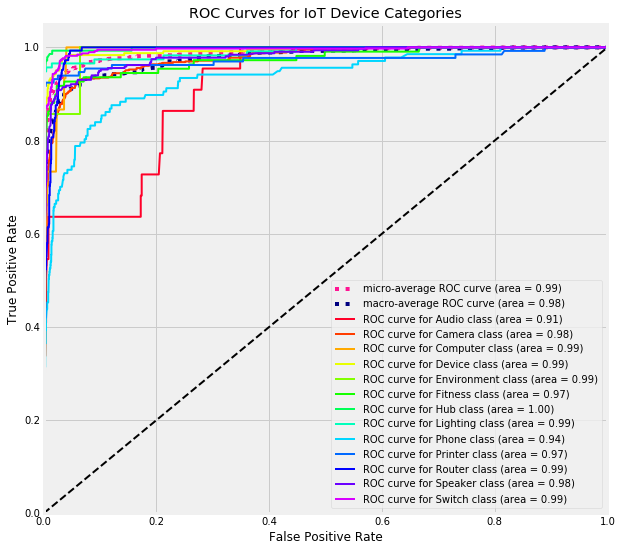

In [73]:
# aggregate all of the false positive rates across all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_categories)]))

# interpolate all of the ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(param['num_class']):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# average the TPR
mean_tpr /= num_categories

# compute the macro average FPR, TPR, and ROC AUC
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# plot all of the ROC curves on a single plot (for comparison)
plt.figure(figsize=(9,9))
plt.plot(fpr['micro'], tpr['micro'],
         label="micro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label="macro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

num_colors = param['num_class']
cm = plt.get_cmap('gist_rainbow')

colors = cycle([cm(1.*i/num_colors) for i in range(num_colors)])

lw = 2
for i, color in zip(range(param['num_class']), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label="ROC curve for "+category_lookup[i]['category']+" class (area = {1:0.2f})"
             "".format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves for IoT Device Categories")
plt.legend(loc="lower right")
plt.show()

It's not a *terrible* plot, but it gets a little messy. We can also plot each class as its own subplot.

First we make a few variables so we can control the layout.

In [74]:
total_subplots = num_categories
plot_grid_cols = 3
plot_grid_rows = total_subplots // plot_grid_cols
plot_grid_rows += total_subplots % plot_grid_cols

position_index = range(1, total_subplots+1)

Now we make the grid of plots.

<Figure size 432x288 with 0 Axes>

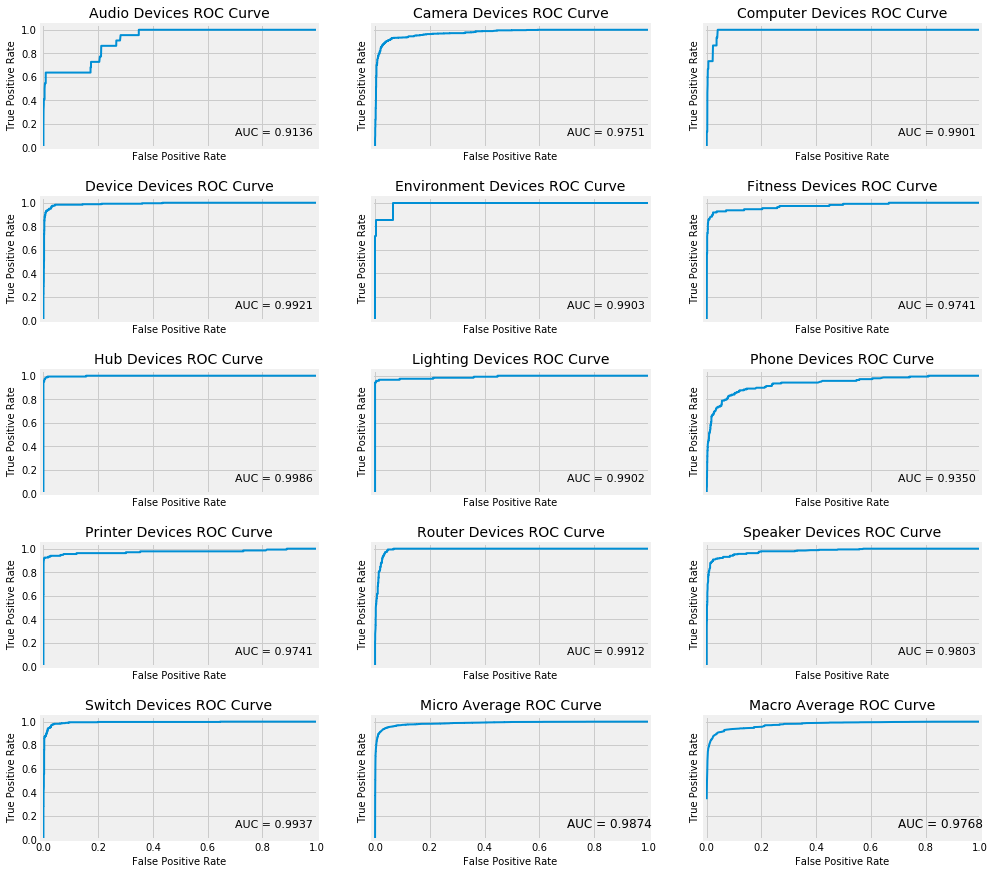

In [75]:
plt.figure()
fig, axs = plt.subplots(plot_grid_rows, plot_grid_cols, sharex=True, sharey=True, figsize=(15,15))

lw = 2

plt_num = 0
for row in range(plot_grid_rows):
    for col in range(plot_grid_cols):
        if(plt_num <= 12):
            axs[row,col].plot(fpr[plt_num], tpr[plt_num], lw=lw)
            axs[row,col].set_title(category_lookup[plt_num]['category']+' Devices ROC Curve', fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc[plt_num]), size=11)
        elif(plt_num == 13):
            axs[row,col].plot(fpr['micro'], tpr['micro'], lw=lw)
            axs[row,col].set_title("Micro Average ROC Curve", fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc['micro']), size=12)
        elif(plt_num == 14):
            axs[row,col].plot(fpr['macro'], tpr['macro'], lw=lw)
            axs[row,col].set_title("Macro Average ROC Curve", fontsize=14)
            axs[row,col].text(0.7, 0.1,"AUC = {:.4f}".format(roc_auc['macro']), size=12)
        axs[row,col].set_xlabel('False Positive Rate', fontsize=10)
        axs[row,col].set_ylabel('True Positive Rate', fontsize=10)
        plt_num += 1
            
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

### Conclusions

As we've shown, it's possible to get fairly decent multiclass classification results for IoT data using only basic features (bytes and packets) when aggregated. This isn't surprising, based on the fact that we used expert knowledge to assign category labels. In addition, the majority of the time, IoT devices are in a "steady state" (idle), and are not heavily influenced by human interaction. This lets us take larger samples (e.g., aggregate to longer time bins) while still maintaining decent classification performance. It should also be noted that this is a very clean dataset. The traffic is mainly IoT traffic (e.g., little traditional compute traffic), and there are no intentional abnormal activities injected (e.g., red teaming).

We used Bro data, but it's also possible to use the raw PCAP data as input for classification. The preprocessing steps are more arduous than for flow data though. It'd be a great exercise...

### More to Explore: Possible Exercises

##### (1) It may be useful to investigate other time binnings. Can you build another model that uses data binned to a different granularity (e.g., 5 minutes)?

In [ ]:
# your work here

##### (2) We used the `sum` of bytes and packets for a device when aggregated to the hour. What about other ways to handle these quantitative features (e.g., average)? Would that improve the classification results?

In [ ]:
# your work here

##### (3) We selected specific parameters for XGBoost. These could probably use a bit more thought. You can [read more about the parameters](https://xgboost.readthedocs.io/en/latest/parameter.html) and try adjusting them on our previous dataset.

In [ ]:
# a reminder about our parameters
print(param)

In [ ]:
# your work here

##### (4) There are additional features in the netflow data that we didn't use. Some other quantitative fields (e.g., duration) and categorical fields (e.g., protocol, service, ports) may be useful for classification. Build another XGBoost model using some/all of these fields.

In [ ]:
# your work here

### References

1. Nadji, Y., "Passive DNS-based Device Identification", *NANOG 67*, https://www.nanog.org/sites/default/files/Nadji.pdf.
1. Shams, R., "Micro- and Macro-average of Precision, Recall, and F-Score", http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html.
1. Sivanathan, A. et al., "Characterizing and Classifying IoT Traffic in Smart Cities and Campuses", *2017 IEEE Conference on Computer Communications Workshops*, May 2017, http://www2.eet.unsw.edu.au/~vijay/pubs/conf/17infocom.pdf.
1. University of New South Wales Internet of Things Network Traffic Data Collection, http://149.171.189.1